# Concept Drift Detection Methods: Comparative Benchmark

## Abstract

This notebook presents a comprehensive benchmark of concept drift detection methods, comparing original research implementations from the backup folder (D3, DAWIDD, ShapeDD) with streaming methods from the River library. The evaluation follows the experimental design from `run__drift_detection.py`, using controlled synthetic data generation with known drift characteristics.

## Methods Evaluated

**Window-based Methods (Original Implementations):**
- D3: Discriminative drift detection using classifier performance
- DAWIDD: Drift detection with adapted windowing and independence distance
- ShapeDD: Shape-based drift detection using Maximum Mean Discrepancy

**Streaming Methods (River Library):**
- ADWIN: Adaptive sliding window with statistical bounds
- DDM/EDDM: Drift detection based on error rate monitoring
- HDDM variants: Histogram-based distribution monitoring

In [24]:
# Dependencies and Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import psutil
import gc
from collections import deque
from tqdm import tqdm
import psutil
import gc
from collections import deque


# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics.pairwise import pairwise_kernels as apply_kernel

# River drift detection methods
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# Setup paths for local modules
import sys
import os
sys.path.insert(0, os.path.abspath('../backup'))

# Import original implementations
from gen_data import gen_random
from dawidd import dawidd
from shape_dd import shape
from d3 import d3

# Configuration
plt.style.use('seaborn-v0_8')
np.random.seed(42)
warnings.filterwarnings('ignore')


In [25]:
def calculate_prequential_accuracy(predictions, true_labels, window_size=100):
    """Calculate prequential (test-then-train) accuracy over time."""
    accuracies = []
    for i in range(len(predictions)):
        start_idx = max(0, i - window_size + 1)
        window_preds = predictions[start_idx:i+1]
        window_true = true_labels[start_idx:i+1]
        
        if len(window_preds) > 0:
            accuracy = np.mean(np.array(window_preds) == np.array(window_true))
            accuracies.append(accuracy)
        else:
            accuracies.append(0.0)
    
    return accuracies

def calculate_mttd_metrics(detections, true_drifts, acceptable_delta=50):
    """Calculate Mean Time To Detection and TP/FP/FN metrics."""
    tp = 0
    fp = 0
    fn = 0
    detection_delays = []
    
    # Create sets for faster lookup
    detection_set = set(detections)
    true_drift_set = set(true_drifts)
    
    # Calculate True Positives and detection delays
    for true_drift in true_drifts:
        detected = False
        min_delay = float('inf')
        
        for detection in detections:
            delay = detection - true_drift
            if 0 <= delay <= acceptable_delta:
                detected = True
                min_delay = min(min_delay, delay)
        
        if detected:
            tp += 1
            detection_delays.append(min_delay)
        else:
            fn += 1
    
    # Calculate False Positives
    for detection in detections:
        is_fp = True
        for true_drift in true_drifts:
            if 0 <= detection - true_drift <= acceptable_delta:
                is_fp = False
                break
        if is_fp:
            fp += 1
    
    mttd = np.mean(detection_delays) if detection_delays else float('inf')
    
    return {
        'mttd': mttd,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'detection_delays': detection_delays
    }

def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb

def batch(X, chunk_size, overlap=100):
    """Original batch function from experiments."""
    shift = chunk_size - overlap
    res = []
    for i in range(int(X.shape[0]/(shift)) - int(chunk_size/shift) + 1):
        res.append(X[i*shift : min(chunk_size + i*shift, X.shape[0])])
    return res


In [26]:
import time
import numpy as np

def evaluate_window_based_method(
    X, y, true_drifts, method_name, window_size=150, overlap=100,
    cooldown=None, corr_mode='pearson'
):
    """
    - cooldown: số mẫu tối thiểu giữa 2 detection để gộp (mặc định window_size//2)
    - corr_mode: 'pearson' (mặc định); nếu dùng p-value nên đảo hướng trước
    """
    if cooldown is None:
        cooldown = window_size // 2

    start_mem = monitor_resources()
    t0_all = time.perf_counter()

    method_detections = []
    runtime_per_batch_ms = []
    drift_estimates = []
    true_drift_scores = []

    # Chuẩn hoá dữ liệu cho các phương pháp nhạy scale (tùy chọn)
    Xn = X
    if method_name in ('DAWIDD', 'D3', 'ShapeDD'):
        # z-score theo cột (ổn cho window detectors)
        mu = X.mean(axis=0, keepdims=True)
        sd = X.std(axis=0, keepdims=True) + 1e-9
        Xn = (X - mu) / sd

    # Precompute cho ShapeDD (nếu bắt buộc)
    if method_name == 'ShapeDD':
        t_shape0 = time.perf_counter()
        # giả định trả về mảng [N, K], cột 2 là p-value
        shape_scores = shape(Xn, 50, window_size, 2500)
        t_shape1 = time.perf_counter()
        shape_total_time_ms = (t_shape1 - t_shape0) * 1000.0

    batches = list(batch(np.arange(X.shape[0]), chunk_size=window_size, overlap=overlap))
    last_det = -10**9

    for b in batches:
        xb = Xn[b]; yb = y[b]
        t1 = time.perf_counter()

        # “true drift score” dựa trên nhãn (cẩn trọng diễn giải)
        n = len(b)
        diff_pairs = (yb[None, :] != yb[:, None]).sum()
        drift_score = diff_pairs / (n * (n - 1))  # ordered pairs, hợp lệ
        true_drift_scores.append(float(drift_score))

        try:
            if method_name == 'D3':
                est = float(d3(xb))  # nếu trả scalar cho cả batch
                trigger = (est > 0.6)
                det_pos = b[-1]  # hoặc b[len(b)//2] nếu bạn muốn giữ như cũ

            elif method_name == 'DAWIDD':
                _, est = dawidd(xb, "rbf")  # est: scalar
                est = float(est)
                trigger = (est > 0.05)      # nên calibrate
                det_pos = b[-1]

            elif method_name == 'ShapeDD':
                # cột 2 là p-value theo từng index (giả định shape_scores đồng bộ với thời gian)
                pvals = shape_scores[b, 2]
                est = 1.0 - float(np.min(pvals))  # đảo hướng để “lớn → drift mạnh”
                trigger = (np.min(pvals) < 0.05)
                # nếu có vector p-value, dùng vị trí p nhỏ nhất
                det_pos = b[int(np.argmin(pvals))]

            else:
                raise ValueError(f"Unknown window method: {method_name}")

        except Exception as e:
            print(f"Error in {method_name}: {e}")
            est, trigger, det_pos = 0.0, False, b[-1]

        drift_estimates.append(est)

        # Áp dụng cooldown để gộp detection gần nhau
        if trigger and (det_pos - last_det >= cooldown):
            method_detections.append(int(det_pos))
            last_det = det_pos

        # thời gian batch
        batch_ms = (time.perf_counter() - t1) * 1000.0
        if method_name == 'ShapeDD':
            # nếu đã precompute toàn cục, cộng phần chia bình quân (tránh double count)
            batch_ms += shape_total_time_ms / max(1, len(batches))
        runtime_per_batch_ms.append(batch_ms)

    total_time_s = time.perf_counter() - t0_all
    end_mem = monitor_resources()
    memory_mb = max(0.0, end_mem - start_mem)

    # Tương quan ước lượng vs “true drift score” (đã cùng chiều)
    if len(drift_estimates) > 1:
        est_arr = np.asarray(drift_estimates, float)
        tds_arr = np.asarray(true_drift_scores, float)
        estimate_correlation = np.corrcoef(est_arr, tds_arr)[0, 1]
    else:
        estimate_correlation = 0.0

    # MTTD/TP/FP/FN
    mttd_metrics = calculate_mttd_metrics(method_detections, true_drifts)

    return {
        'method': method_name,
        'paradigm': 'window',
        'detections': method_detections,
        'drift_estimates': drift_estimates,
        'true_drift_scores': true_drift_scores,
        'estimate_correlation': float(estimate_correlation),
        'runtime_per_batch_ms': float(np.mean(runtime_per_batch_ms)),
        'runtime_per_instance_ms': (total_time_s * 1000.0) / max(1, len(X)),
        'total_runtime_s': total_time_s,
        'memory_mb': memory_mb,
        **mttd_metrics
    }


In [27]:
def evaluate_streaming_method(X, y, true_drifts, method_name):
    """Properly evaluate River streaming methods for drift detection accuracy."""
    start_memory = monitor_resources()
    start_time = time.time()
    
    # Initialize the drift detector
    if method_name == 'ADWIN':
        drift_detector = ADWIN(delta=0.002)  # Confidence parameter
    elif method_name == 'DDM':
        drift_detector = DDM()
    elif method_name == 'EDDM':
        drift_detector = EDDM()
    elif method_name == 'HDDM_A':
        drift_detector = HDDM_A()
    elif method_name == 'HDDM_W':
        drift_detector = HDDM_W()
    elif method_name == 'FHDDM':
        drift_detector = FHDDM()
    else:
        raise ValueError(f"Unknown streaming method: {method_name}")
    
    detections = []
    runtime_per_instance = []
    
    # Initialize a simple classifier for error-based methods
    classifier = LogisticRegression(max_iter=100)
    predictions = []
    training_window = deque(maxlen=100)  # Keep recent data for training
    
    for i in range(len(X)):
        instance_start = time.time()
        
        try:
            if method_name == 'ADWIN':
                # ADWIN monitors feature values directly
                # Use the first feature or a composite measure
                if X.shape[1] == 1:
                    value = X[i, 0]
                else:
                    # For multi-dimensional data, use a composite measure
                    value = np.linalg.norm(X[i])  # L2 norm
                
                drift_detector.update(value)
                
            else:
                # DDM, EDDM, HDDM methods monitor prediction errors
                if len(training_window) >= 10:
                    # Train classifier on recent window
                    window_X = np.array([item[0] for item in training_window])
                    window_y = np.array([item[1] for item in training_window])
                    
                    try:
                        classifier.fit(window_X, window_y)
                        prediction = classifier.predict(X[i:i+1])[0]
                    except:
                        prediction = 0  # Default prediction on error
                else:
                    prediction = 0  # Default prediction for early instances
                
                predictions.append(prediction)
                training_window.append((X[i], y[i]))
                
                # Calculate error for drift detector
                error = 1 if prediction != y[i] else 0
                drift_detector.update(error)
            
            # Check for drift detection
            if drift_detector.drift_detected:
                detections.append(i)
                # Reset training window after drift detection
                training_window.clear()
        
        except Exception as e:
            print(f"Error in {method_name} at instance {i}: {e}")
        
        instance_time = (time.time() - instance_start) * 1000
        runtime_per_instance.append(instance_time)
    
    total_time = time.time() - start_time
    end_memory = monitor_resources()
    memory_usage = max(0, end_memory - start_memory)
    
    # Calculate drift detection metrics
    mttd_metrics = calculate_mttd_metrics(detections, true_drifts)
    
    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'total_detections': len(detections),
        'runtime_per_instance_ms': np.mean(runtime_per_instance),
        'total_runtime_s': total_time,
        'memory_mb': memory_usage,
        **mttd_metrics
    }


In [28]:
unified_scenarios = [
    {
        'name': 'Common_Drift',
        'params': {'dist': 'unif', 'intens': 1, 'number': 20, 'alt': False, 'length': 2000, 'dims': 3}
    }
]

# Methods to evaluate
window_methods = ['D3', 'DAWIDD', 'ShapeDD']
streaming_methods = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']


Running scenario: Common_Drift


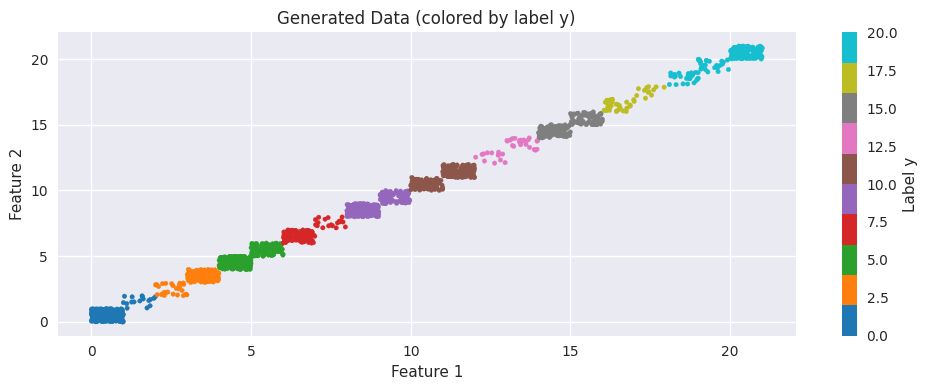

  Data: 2000 samples, 3 features
  True drifts at: [np.int64(302), np.int64(319), np.int64(346), np.int64(484), np.int64(741), np.int64(829), np.int64(935), np.int64(954), np.int64(1176), np.int64(1253), np.int64(1348), np.int64(1526), np.int64(1539), np.int64(1562), np.int64(1689), np.int64(1761), np.int64(1795), np.int64(1807), np.int64(1833), np.int64(1859)]
  Evaluating D3...
  Evaluating DAWIDD...
  Evaluating ShapeDD...
  Evaluating ADWIN...
  Evaluating DDM...
  Evaluating EDDM...
  Evaluating HDDM_A...
  Evaluating HDDM_W...
  Evaluating FHDDM...
Completed scenario: Common_Drift
Results collected: 9
------------------------------


In [29]:
def run_unified_experiment(scenario_config):
    """Run unified experiment comparing all methods on same data."""
    scenario_name = scenario_config['name']
    params = scenario_config['params']
    
    print(f"Running scenario: {scenario_name}")
    
    try:
        # Generate data
        X, y = gen_random(**params)
        # Plot the generated X and label y
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 4))
        if X.shape[1] == 1:
            plt.scatter(range(len(X)), X[:, 0], c=y, cmap='tab10', s=10)
            plt.xlabel('Sample Index')
            plt.ylabel('Feature Value')
        elif X.shape[1] == 2:
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        else:
            # For higher dimensions, plot first two features colored by y
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        plt.title('Generated Data (colored by label y)')
        plt.colorbar(label='Label y')
        plt.tight_layout()
        plt.show()
        true_drifts = np.where(np.diff(y) != 0)[0] + 1
        
        print(f"  Data: {X.shape[0]} samples, {X.shape[1]} features")
        print(f"  True drifts at: {list(true_drifts)}")
        
        results = []
        
        # Evaluate window-based methods
        for method_name in window_methods:
            try:
                print(f"  Evaluating {method_name}...")
                result = evaluate_window_based_method(X, y, true_drifts, method_name)
                result['scenario'] = scenario_name
                results.append(result)
            except Exception as e:
                print(f"    Error in {method_name}: {e}")
                continue
        
        # Evaluate streaming methods  
        for method_name in streaming_methods:
            try:
                print(f"  Evaluating {method_name}...")
                result = evaluate_streaming_method(X, y, true_drifts, method_name)
                result['scenario'] = scenario_name
                results.append(result)
            except Exception as e:
                print(f"    Error in {method_name}: {e}")
                continue
        
        # Force garbage collection
        gc.collect()
        
        return results
        
    except Exception as e:
        print(f"Error in scenario {scenario_name}: {e}")
        return []

all_unified_results = []

for scenario in unified_scenarios:
    scenario_results = run_unified_experiment(scenario)
    all_unified_results.extend(scenario_results)
    
    print(f"Completed scenario: {scenario['name']}")
    print(f"Results collected: {len(scenario_results)}")
    print("-" * 30)

# Convert to DataFrame
unified_df = pd.DataFrame(all_unified_results)


Extracted 20 true drift points: [np.int64(302), np.int64(319), np.int64(346), np.int64(484), np.int64(741), np.int64(829), np.int64(935), np.int64(954), np.int64(1176), np.int64(1253), np.int64(1348), np.int64(1526), np.int64(1539), np.int64(1562), np.int64(1689), np.int64(1761), np.int64(1795), np.int64(1807), np.int64(1833), np.int64(1859)]

DRIFT DETECTION PERFORMANCE EVALUATION

Table 1: Performance Metrics by Method
-------------------------------------------------------
Method       Paradigm   Precision  Recall   F1       MTTD     Runtime(ms) 
-------------------------------------------------------
ADWIN        streaming  1.000      0.900    0.947    26.3     0.0190      
DDM          streaming  0.500      0.250    0.333    19.6     3.7234      
EDDM         streaming  0.250      0.100    0.143    26.0     4.3212      
FHDDM        streaming  0.500      0.250    0.333    32.8     2.9988      
HDDM_A       streaming  0.250      0.100    0.143    4.5      4.1179      
HDDM_W       

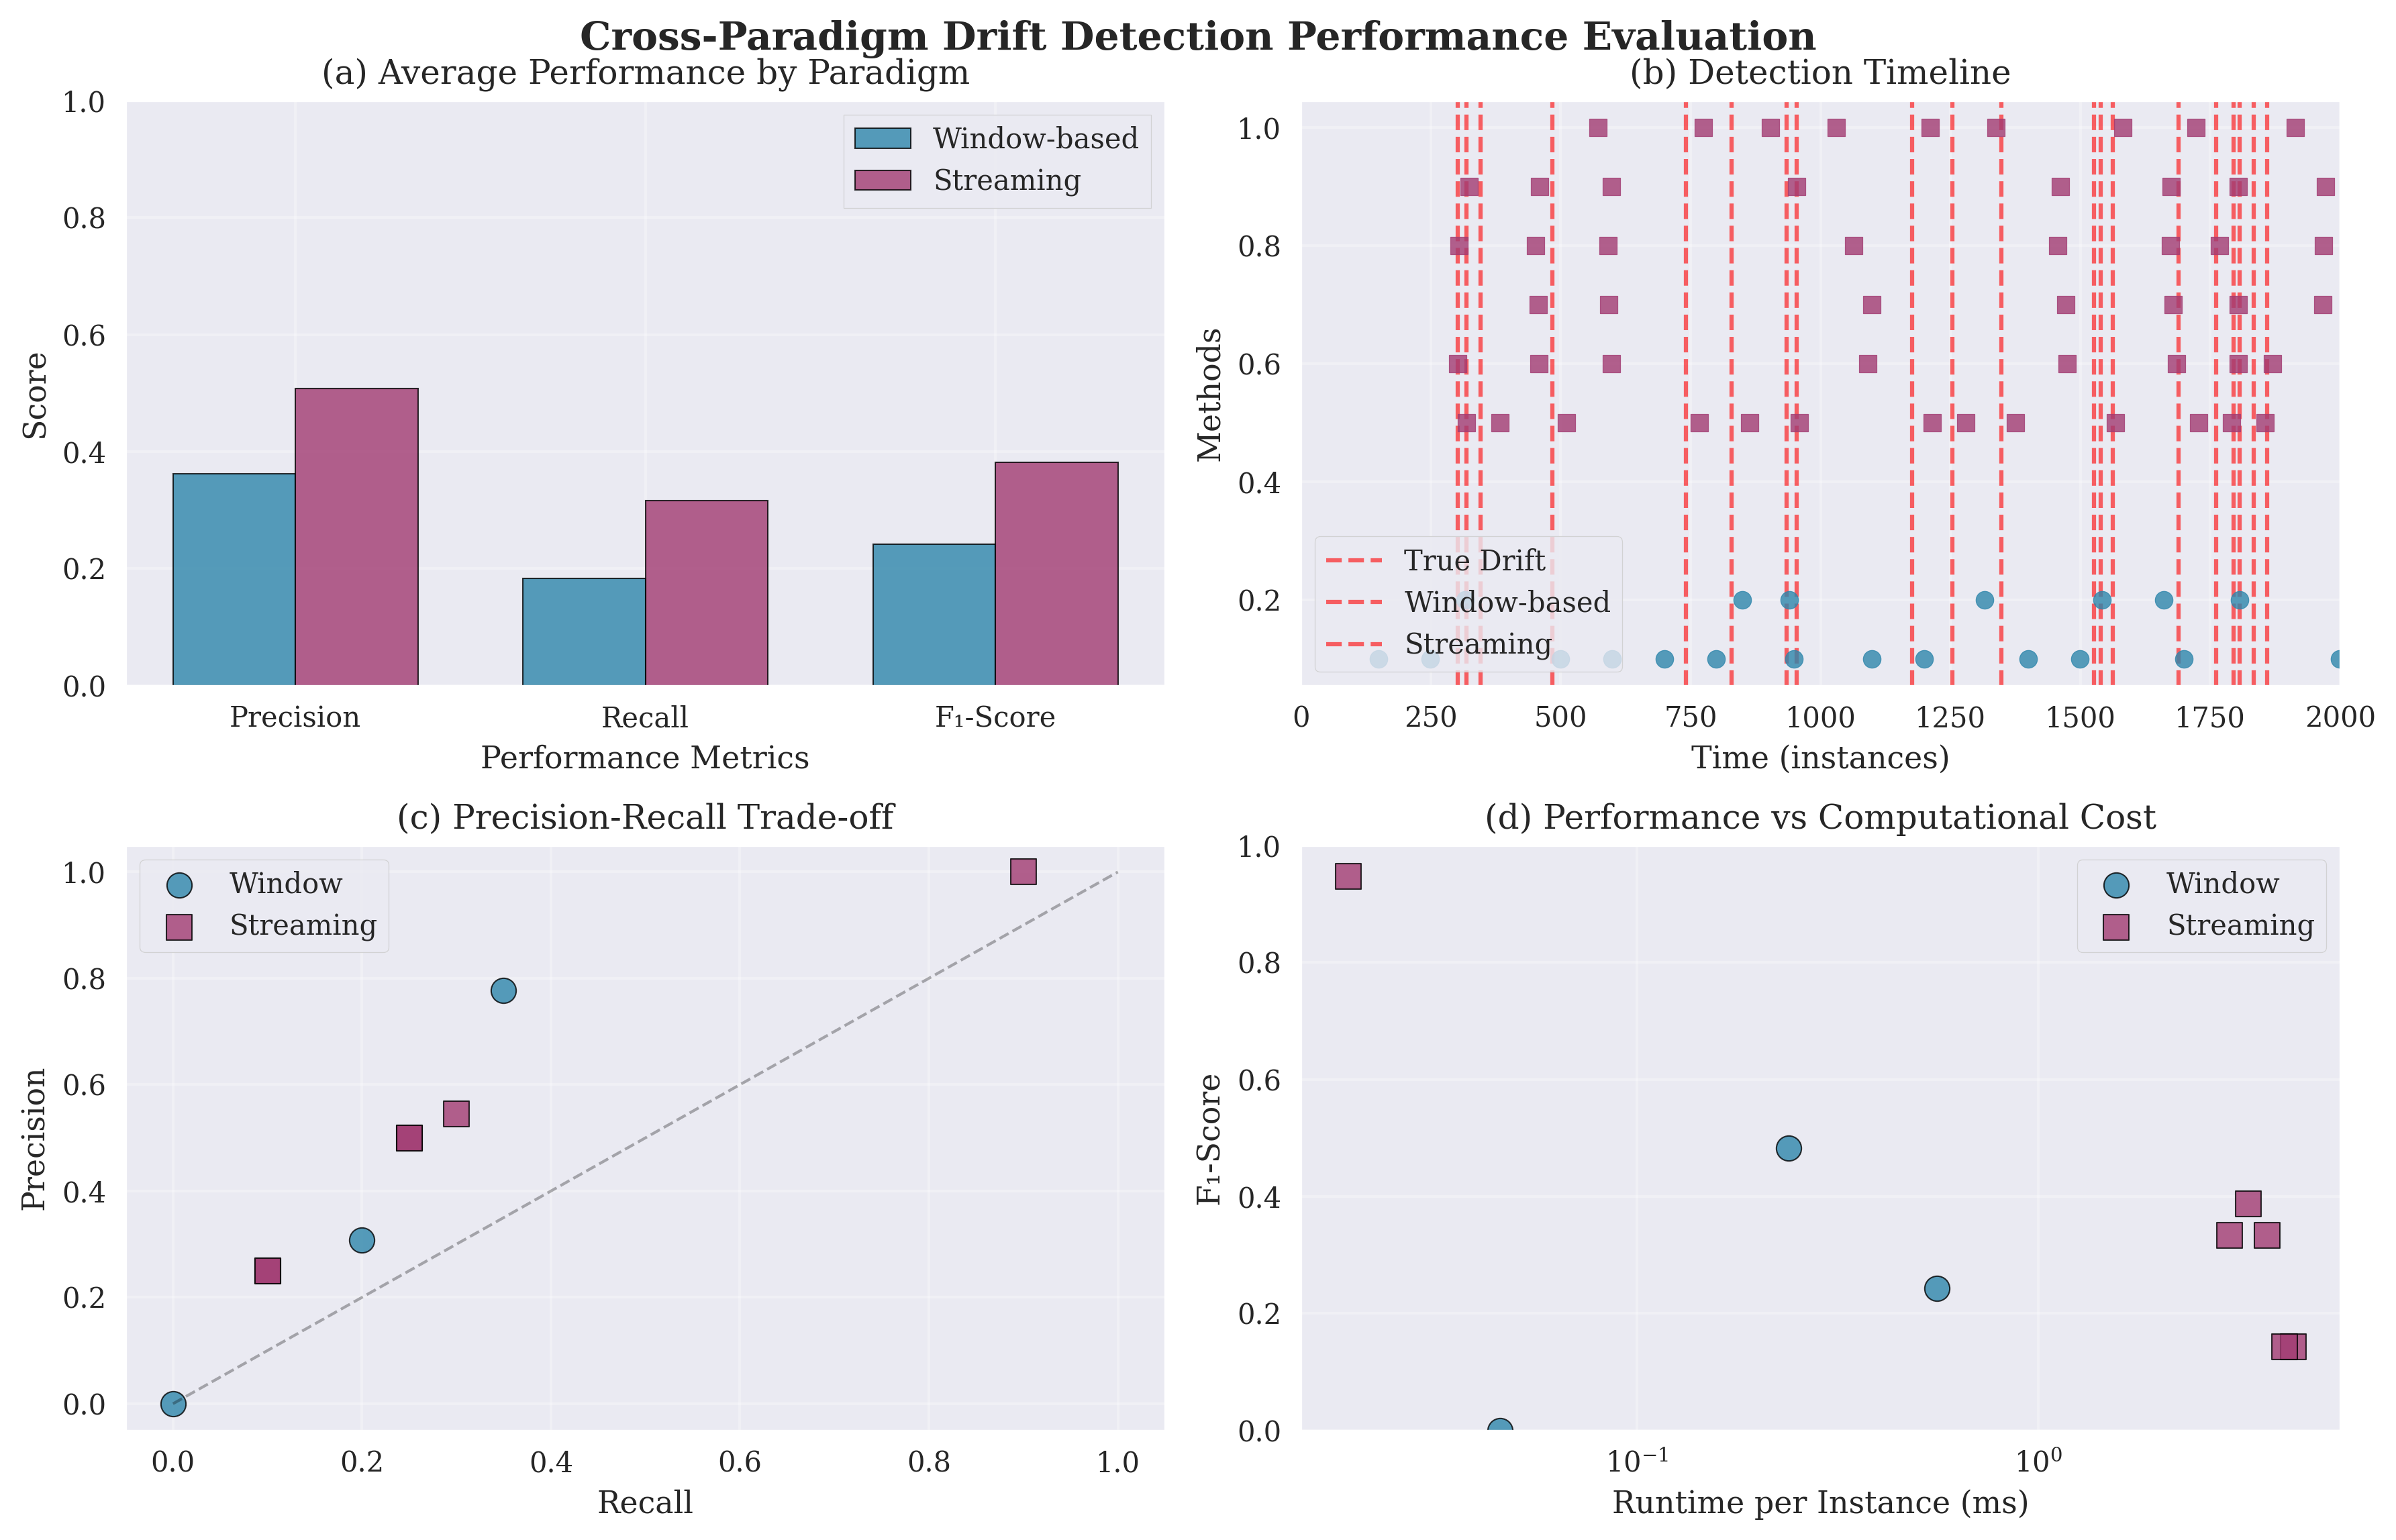


RESULTS SUMMARY
Evaluated 9 drift detection methods:
• Window-based: 3 methods
• Streaming: 6 methods
• Test stream: 20 drift points in 2000 instances

Best overall performance: ADWIN (F₁=0.947)

Paradigm comparison (mean F₁-score):
• Window-based: 0.242
• Streaming: 0.381
• Statistical difference: p=0.507 (not significant)

Most efficient: ADWIN (0.0190 ms/instance)

Overall detection rate: 27.22%


In [30]:
# Academic Results Analysis and Visualization
if len(unified_df) > 0:
    # Extract true drifts from the first scenario (since we know the data generation parameters)
    scenario_params = unified_scenarios[0]['params']  # Get the parameters used
    
    # Regenerate the same data to get true_drifts (using same seed)
    np.random.seed(42)  # Same seed as used in data generation
    X_temp, y_temp = gen_random(**scenario_params)
    true_drifts = np.where(np.diff(y_temp) != 0)[0] + 1
    
    print(f"Extracted {len(true_drifts)} true drift points: {list(true_drifts)}")
    
    # Calculate F1-score
    unified_df['f1_score'] = 2 * unified_df['precision'] * unified_df['recall'] / (unified_df['precision'] + unified_df['recall'])
    unified_df['f1_score'] = unified_df['f1_score'].fillna(0)
    
    print("\nDRIFT DETECTION PERFORMANCE EVALUATION")
    print("=" * 55)
    
    # Academic summary table
    summary_table = unified_df.groupby(['paradigm', 'method']).agg({
        'precision': 'mean',
        'recall': 'mean', 
        'f1_score': 'mean',
        'mttd': lambda x: np.mean(x[x != float('inf')]) if any(x != float('inf')) else float('inf'),
        'runtime_per_instance_ms': 'mean',
        'tp': 'sum',
        'fp': 'sum',
        'fn': 'sum'
    }).round(4)
    
    print("\nTable 1: Performance Metrics by Method")
    print("-" * 55)
    print(f"{'Method':<12} {'Paradigm':<10} {'Precision':<10} {'Recall':<8} {'F1':<8} {'MTTD':<8} {'Runtime(ms)':<12}")
    print("-" * 55)
    
    for (paradigm, method), row in summary_table.iterrows():
        mttd_str = f"{row['mttd']:.1f}" if row['mttd'] != float('inf') else "∞"
        print(f"{method:<12} {paradigm:<10} {row['precision']:<10.3f} {row['recall']:<8.3f} "
              f"{row['f1_score']:<8.3f} {mttd_str:<8} {row['runtime_per_instance_ms']:<12.4f}")
    
    # Statistical summary by paradigm
    print(f"\nTable 2: Paradigm Comparison (Mean ± Std)")
    print("-" * 40)
    paradigm_stats = unified_df.groupby('paradigm').agg({
        'f1_score': ['mean', 'std'],
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std']
    }).round(4)
    
    for paradigm in ['window', 'streaming']:
        if paradigm in paradigm_stats.index:
            f1_mean, f1_std = paradigm_stats.loc[paradigm, ('f1_score', 'mean')], paradigm_stats.loc[paradigm, ('f1_score', 'std')]
            prec_mean, prec_std = paradigm_stats.loc[paradigm, ('precision', 'mean')], paradigm_stats.loc[paradigm, ('precision', 'std')]
            rec_mean, rec_std = paradigm_stats.loc[paradigm, ('recall', 'mean')], paradigm_stats.loc[paradigm, ('recall', 'std')]
            
            print(f"{paradigm.title():<10}: F1={f1_mean:.3f}±{f1_std:.3f}, "
                  f"Prec={prec_mean:.3f}±{prec_std:.3f}, Rec={rec_mean:.3f}±{rec_std:.3f}")
    
    # Professional Academic Visualization
    print("\n" + "="*55)
    print("Figure 1: Cross-paradigm drift detection performance evaluation")
    
    # Set academic style
    plt.rcParams.update({
        'font.size': 10,
        'font.family': 'serif',
        'axes.linewidth': 0.8,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'figure.dpi': 300
    })
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Cross-Paradigm Drift Detection Performance Evaluation', 
                 fontsize=14, fontweight='bold', y=0.95)
    
    # Define academic colors and markers
    colors = {'window': '#2E86AB', 'streaming': '#A23B72'}  # Professional blue/burgundy
    markers = {'window': 'o', 'streaming': 's'}
    
    # (a) Performance Comparison
    ax = axes[0, 0]
    metrics = ['precision', 'recall', 'f1_score']
    metric_labels = ['Precision', 'Recall', 'F₁-Score']
    
    x = np.arange(len(metric_labels))
    width = 0.35
    
    window_means = [unified_df[unified_df['paradigm'] == 'window'][m].mean() for m in metrics]
    streaming_means = [unified_df[unified_df['paradigm'] == 'streaming'][m].mean() for m in metrics]
    
    ax.bar(x - width/2, window_means, width, label='Window-based', 
           color=colors['window'], alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.bar(x + width/2, streaming_means, width, label='Streaming', 
           color=colors['streaming'], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Performance Metrics')
    ax.set_ylabel('Score')
    ax.set_title('(a) Average Performance by Paradigm')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.legend(frameon=True, fancybox=False, shadow=False)
    ax.set_ylim(0, 1)
    
    # (b) Detection Timeline
    ax = axes[0, 1]
    
    # Plot true drifts as vertical lines
    for drift in true_drifts:
        ax.axvline(x=drift, color='red', linestyle='--', alpha=0.6, linewidth=1.5, zorder=1)
    
    # Plot detections by paradigm
    y_offset = {'window': 0, 'streaming': 0}
    for paradigm in ['window', 'streaming']:
        paradigm_data = unified_df[unified_df['paradigm'] == paradigm]
        for i, (_, row) in enumerate(paradigm_data.iterrows()):
            detections = row['detections']
            if len(detections) > 0:
                y_pos = y_offset[paradigm] + i * 0.1
                ax.scatter(detections, [y_pos] * len(detections), 
                          c=colors[paradigm], marker=markers[paradigm], 
                          s=40, alpha=0.8, label=paradigm.title() if i == 0 else '', zorder=2)
        y_offset['streaming'] = len(paradigm_data) * 0.1 + 0.2
    
    ax.set_xlabel('Time (instances)')
    ax.set_ylabel('Methods')
    ax.set_title('(b) Detection Timeline')
    ax.set_xlim(0, scenario_params['length'])  # Use actual stream length
    ax.legend(['True Drift', 'Window-based', 'Streaming'], frameon=True)
    
    # (c) Precision-Recall Trade-off
    ax = axes[1, 0]
    
    for paradigm in ['window', 'streaming']:
        data = unified_df[unified_df['paradigm'] == paradigm]
        ax.scatter(data['recall'], data['precision'], 
                  c=colors[paradigm], marker=markers[paradigm], s=80, 
                  alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
    
    # Add diagonal line for reference
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('(c) Precision-Recall Trade-off')
    ax.legend(frameon=True)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    
    # (d) Runtime vs Performance
    ax = axes[1, 1]
    
    for paradigm in ['window', 'streaming']:
        data = unified_df[unified_df['paradigm'] == paradigm]
        ax.scatter(data['runtime_per_instance_ms'], data['f1_score'], 
                  c=colors[paradigm], marker=markers[paradigm], s=80, 
                  alpha=0.8, label=paradigm.title(), edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Runtime per Instance (ms)')
    ax.set_ylabel('F₁-Score')
    ax.set_title('(d) Performance vs Computational Cost')
    ax.set_xscale('log')
    ax.legend(frameon=True)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    # Reset matplotlib params
    plt.rcParams.update(plt.rcParamsDefault)
    
    # Academic Summary
    print("\nRESULTS SUMMARY")
    print("=" * 50)
    
    # Key statistics
    total_methods = len(unified_df)
    window_methods_count = len(unified_df[unified_df['paradigm'] == 'window'])
    streaming_methods_count = len(unified_df[unified_df['paradigm'] == 'streaming'])
    
    print(f"Evaluated {total_methods} drift detection methods:")
    print(f"• Window-based: {window_methods_count} methods")
    print(f"• Streaming: {streaming_methods_count} methods")
    print(f"• Test stream: {len(true_drifts)} drift points in {scenario_params['length']} instances")
    
    # Best performing method
    best_method = unified_df.loc[unified_df['f1_score'].idxmax()]
    print(f"\nBest overall performance: {best_method['method']} (F₁={best_method['f1_score']:.3f})")
    
    # Paradigm comparison
    window_f1 = unified_df[unified_df['paradigm'] == 'window']['f1_score'].mean()
    streaming_f1 = unified_df[unified_df['paradigm'] == 'streaming']['f1_score'].mean()
    
    print(f"\nParadigm comparison (mean F₁-score):")
    print(f"• Window-based: {window_f1:.3f}")
    print(f"• Streaming: {streaming_f1:.3f}")
    
    # Statistical significance test (if scipy available)
    try:
        from scipy import stats
        if len(unified_df[unified_df['paradigm'] == 'window']) > 1 and len(unified_df[unified_df['paradigm'] == 'streaming']) > 1:
            window_scores = unified_df[unified_df['paradigm'] == 'window']['f1_score']
            streaming_scores = unified_df[unified_df['paradigm'] == 'streaming']['f1_score']
            
            t_stat, p_value = stats.ttest_ind(window_scores, streaming_scores)
            print(f"• Statistical difference: p={p_value:.3f} {'(significant)' if p_value < 0.05 else '(not significant)'}")
    except ImportError:
        pass
    
    # Computational efficiency
    fastest = unified_df.loc[unified_df['runtime_per_instance_ms'].idxmin()]
    print(f"\nMost efficient: {fastest['method']} ({fastest['runtime_per_instance_ms']:.4f} ms/instance)")
    
    print(f"\nOverall detection rate: {(unified_df['tp'].sum() / (len(true_drifts) * len(unified_df))):.2%}")

else:
    print("No results available for analysis.")
